In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["ckanapi", "geopandas"]


_colab_install_missing_deps(deps)

# Programmatically query the IOOS Data Catalog for a specific observation type

Created: 2024-09-17

Updated: 2024-09-19

Author: [Mathew Biddle](mailto:mathew.biddle@noaa.gov)

In this notebook we highlight the ability to search the [IOOS Data Catalog](https://data.ioos.us/) for a specific subset of observations using the [CKAN](https://ckan.org/) web accessible Application Programming Interface (API). 

For this example, we want to look for observations of oxygen in the water column across the IOOS Catalog. As part of the [IOOS Metadata Profile](https://ioos.github.io/ioos-metadata/), which the US IOOS community uses to publish datasets, we know that each Regional Association and DAC will be following the [Climate and Forecast (CF) Conventions](http://cfconventions.org/) and using CF `standard_names` to describe their datasets. So, with that assumption, we can search across the IOOS Data catalog for datasets with the CF standard names that contain `oxygen` and `sea_water`. Then, we can build a simple map to show the geographical distribution of those datasets.

## Build CKAN API query base.

Uses https://github.com/ckan/ckanapi

In [2]:
from ckanapi import RemoteCKAN

ua = "ckanapiioos/1.0 (+https://ioos.us/)"

# ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN("https://data.ioos.us", user_agent=ua)
ioos_catalog

## What organizations are in the catalog?

Tell me what organizations are there.

In [3]:
orgs = ioos_catalog.action.organization_list()
print(orgs)

['aoos', 'caricoos', 'cdip', 'cencoos', 'comt', 'gcoos', 'glider-dac', 'glos', 'hf-radar-dac', 'ioos', 'maracoos', 'nanoos', 'neracoos', 'noaa-co-ops', 'noaa-ndbc', 'oceansites', 'pacioos', 'sccoos', 'secoora', 'unidata', 'usgs', 'us-navy']


## How many datasets are we searching across?

Grab all the datasets available and return the count.

In [4]:
# datasets = ioos_catalog.action.package_search(fq='+cf_standard_names:mass_concentration_of_oxygen_in_sea_water', rows=50)
datasets = ioos_catalog.action.package_search()
datasets["count"]

44311

## Grab the most recent applicable CF standard names

Collect [CF standard names](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html) that contain `oxygen` and `sea_water` from the CF standard name list.

In [5]:
import pandas as pd

url = "https://cfconventions.org/Data/cf-standard-names/current/src/cf-standard-name-table.xml"

tbl_version = pd.read_xml(url, xpath="./*")["version_number"][0].astype(int)
df = pd.read_xml(url, xpath="entry")

std_names = df.loc[
    (df["id"].str.contains("oxygen") & df["id"].str.contains("sea_water"))
]

print(f"CF Standard Name Table: {tbl_version}")

std_names[["id", "description"]]

CF Standard Name Table: 86


,id,description
469,depth_at_shallowest_local_minimum_in_vertical_...,Depth is the vertical distance below the surfa...
624,fractional_saturation_of_oxygen_in_sea_water,Fractional saturation is the ratio of some mea...
1357,mass_concentration_of_oxygen_in_sea_water,Mass concentration means mass per unit volume ...
1725,mole_concentration_of_dissolved_molecular_oxyg...,Mole concentration means number of moles per u...
1726,mole_concentration_of_dissolved_molecular_oxyg...,"""Mole concentration at saturation"" means the m..."
1727,mole_concentration_of_dissolved_molecular_oxyg...,Mole concentration means number of moles per u...
1825,mole_concentration_of_preformed_dissolved_mole...,"""Mole concentration"" means the number of moles..."
1996,moles_of_oxygen_per_unit_mass_in_sea_water,"moles_of_X_per_unit_mass_inY is also called ""m..."
3203,surface_molecular_oxygen_partial_pressure_diff...,"The surface called ""surface"" means the lower b..."
3700,temperature_of_sensor_for_oxygen_in_sea_water,Temperature_of_sensor_for_oxygen_in_sea_water ...


## Search across IOOS Data Catalog using CKAN API

Search the IOOS Data Catalog for CF standard names that match those above.

In [6]:
import time

from ckanapi import RemoteCKAN
from ckanapi.errors import CKANAPIError

ua = "ckanapiioos/1.0 (+https://ioos.us/)"

ioos_catalog = RemoteCKAN("https://data.ioos.us", user_agent=ua)
ioos_catalog

df_out = pd.DataFrame()

for std_name in std_names["id"]:

    print(std_name)

    fq = f"+cf_standard_names:{std_name}"

    result_count = 0

    while True:
        try:
            datasets = ioos_catalog.action.package_search(fq=fq, rows=500)
        except CKANAPIError:
            continue

        num_results = datasets["count"]

        print(f"num_results: {num_results}, result_count: {result_count}")

        for dataset in datasets["results"]:
            # print(dataset['title'])
            df = pd.DataFrame(
                {
                    "title": [dataset["title"]],
                    "url": [dataset["resources"][0]["url"]],
                    "org": [dataset["organization"]["title"]],
                    "std_name": std_name,
                }
            )

            df_out = pd.concat([df_out, df])
            result_count = result_count + 1

        time.sleep(1)

        if result_count >= num_results:
            print(f"num_results: {num_results}, result_count: {result_count}")
            break

df_out

depth_at_shallowest_local_minimum_in_vertical_profile_of_mole_concentration_of_dissolved_molecular_oxygen_in_sea_water
num_results: 0, result_count: 0
num_results: 0, result_count: 0
fractional_saturation_of_oxygen_in_sea_water
num_results: 987, result_count: 0
num_results: 987, result_count: 500
num_results: 987, result_count: 1000
mass_concentration_of_oxygen_in_sea_water
num_results: 2735, result_count: 0
num_results: 2735, result_count: 500
num_results: 2735, result_count: 1000
num_results: 2735, result_count: 1500
num_results: 2735, result_count: 2000
num_results: 2735, result_count: 2500
num_results: 2735, result_count: 3000
mole_concentration_of_dissolved_molecular_oxygen_in_sea_water
num_results: 300, result_count: 0
num_results: 300, result_count: 300
mole_concentration_of_dissolved_molecular_oxygen_in_sea_water_at_saturation
num_results: 0, result_count: 0
num_results: 0, result_count: 0
mole_concentration_of_dissolved_molecular_oxygen_in_sea_water_at_shallowest_local_minimum

,title,url,org,std_name
0,St. Lucie Estuary - South Fork 2 (SLE-SF2),https://erddap.secoora.org/erddap/tabledap/st-...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,"Neuse River at Marker 15 (ModMon 70, AWS J8903...",https://erddap.secoora.org/erddap/tabledap/neu...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,Pamlico Sound at PS9 (ModMon),https://erddap.secoora.org/erddap/tabledap/pam...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,Indian River Lagoon - Jensen Beach (IRL-JB),https://erddap.secoora.org/erddap/tabledap/ind...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,Indian River Lagoon - Sebastian (IRL-SB),https://erddap.secoora.org/erddap/tabledap/ind...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
...,...,...,...,...
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water


## Do some summarizing of the responses

The DataFrame of the matching datasets is quite large. I wonder what the distribution of those datasets across organizations looks like? Let's use [pandas.groupby()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) to generate some statistics about how many datasets are provided, matching our criteria, by which organization.

In [7]:
df_out.groupby(by="org").count()

,title,url,std_name
org,,,
CeNCOOS,2,2,2
GCOOS,2208,2208,2208
Glider DAC,2625,2625,2625
NERACOOS,28,28,28
PacIOOS,16,16,16
SECOORA,606,606,606


## Drop the Glider DAC data

Glider DAC data are already making it to NCEI, so we can drop those entries.

In [8]:
df_out_no_glider = df_out.loc[~df_out["org"].str.contains("Glider DAC")]
df_out_no_glider.groupby(by="org").count()

,title,url,std_name
org,,,
CeNCOOS,2,2,2
GCOOS,2208,2208,2208
NERACOOS,28,28,28
PacIOOS,16,16,16
SECOORA,606,606,606


## Digging into some of the nuances

There are still quite a lot of datasets from each organization. As our search above looked for each CF standard_name across all the datasets, there might be duplicate datasets which have multiple matching CF standard names. ie. one dataset might have both `mass_concentration_of_oxygen_in_sea_water` and `fractional_saturation_of_oxygen_in_sea_water`, but we only need to know that it's one dataset.

As we only need to know about the unique datasets, let's count how many unique dataset urls we have.

In [9]:
df_out_no_glider.groupby(by="url").count()

,title,org,std_name
url,,,
http://www.neracoos.org/erddap/tabledap/A01_optode_all,3,3,3
http://www.neracoos.org/erddap/tabledap/GRBGBWQ_NERRS,4,4,4
http://www.neracoos.org/erddap/tabledap/GRBLRWQ_NERRS,4,4,4
http://www.neracoos.org/erddap/tabledap/LOBO_CSV_65,1,1,1
http://www.neracoos.org/erddap/tabledap/URI_168-MV_BottomSonde,16,16,16
...,...,...,...
https://gcoos5.geos.tamu.edu/erddap/tabledap/deepwater_pe972250_ctd,6,6,6
https://gcoos5.geos.tamu.edu/erddap/tabledap/deepwater_pe972274_ctd,6,6,6
https://gcoos5.geos.tamu.edu/erddap/tabledap/deepwater_st093lay_ctd,6,6,6


## Drop duplicate records

As you can see above, there are a lot of duplicate dataset urls which we can simplify down. We identify duplicates by looking at the URL, which should be unique for each dataset, and drop the duplicates.

In [10]:
df_out_nodups_no_glider = df_out_no_glider.drop_duplicates(subset=["url"], keep="last")

df_out_nodups_no_glider

,title,url,org,std_name
0,Neuse River near the south shore (ModMon 96),https://erddap.secoora.org/erddap/tabledap/neu...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,"Great Bay,NH. Lamprey River WQ station",http://www.neracoos.org/erddap/tabledap/GRBLRW...,NERACOOS,fractional_saturation_of_oxygen_in_sea_water
0,"Great Bay,NH. Great Bay WQ station",http://www.neracoos.org/erddap/tabledap/GRBGBW...,NERACOOS,fractional_saturation_of_oxygen_in_sea_water
0,"WACCASASSA RIVER NR GULF HAMMOCK, FLA. (USGS 0...",https://erddap.secoora.org/erddap/tabledap/gov...,SECOORA,mass_concentration_of_oxygen_in_sea_water
0,"LITTLE BACK RIVER AT HOG ISLAND, NEAR SAVANNAH...",https://erddap.secoora.org/erddap/tabledap/gov...,SECOORA,mass_concentration_of_oxygen_in_sea_water
...,...,...,...,...
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water


## How many endpoints are not ERDDAP?

Now we have a unique list of datasets which match our CF standard name criteria. Since we have some background in using [ERDDAP to query for data](https://ioos.github.io/ioos_code_lab/content/code_gallery/data_access_notebooks/2017-03-21-ERDDAP_IOOS_Sensor_Map.html), let's take a look at what other endpoints each of the datasets are using.

_Hint: We know ERDDAP systems typically have `erddap` in their urls._

In [11]:
df_out_nodups_no_glider.loc[~df_out_nodups_no_glider["url"].str.contains("erddap")]

,title,url,org,std_name


## What's the remaining distribution?

This is the distribution of unique datasets found in the IOOS Data Catalog which have a CF Standard Name that contains the work `oxygen` and `sea_water`. We've dropped out the Glider DAC datasets as, theoretically, those are in NCEI already.

In [12]:
df_out_nodups_no_glider.groupby(by="org").count()

,title,url,std_name
org,,,
CeNCOOS,2,2,2
GCOOS,378,378,378
NERACOOS,5,5,5
PacIOOS,2,2,2
SECOORA,35,35,35


## Ingest data

Let's rip through all of the datasets, grab the data as a table (including units) and make a monster dictionary. This takes a bit.

In [13]:
dict_out_final = {}

for index, row in df_out_nodups_no_glider.iterrows():
    dict_out_final["{}".format(row["title"])] = pd.read_csv(
        "{}.csvp".format(row["url"]), low_memory=False
    )

Let's take a quick look at one of the DataFrames.

Transpose it when we print, so we can see all the columns.

In [14]:
dict_out_final['"Deepwater CTD - pe972218.ctd.nc - 29.25N, -87.89W - 1997-03-21"'].head(
    5
).T

,0,1,2,3,4
profile,NaN,NaN,NaN,NaN,NaN
time (UTC),1968-01-20T03:14:07Z,1968-01-20T03:14:07Z,1968-01-20T03:14:07Z,1968-01-20T03:14:07Z,1968-01-20T03:14:07Z
latitude (degrees_north),29.2472,29.2472,29.2472,29.2472,29.2472
longitude (degrees_east),-87.888901,-87.888901,-87.888901,-87.888901,-87.888901
numberOfLevel,351,351,351,351,351
depth (m),7.0,8.0,9.0,10.0,11.0
temperature (degree_C),20.823,20.832001,20.837,20.837999,20.854
salinity (PSU),35.321999,35.332001,35.335999,35.338001,35.345001
oxygen (milliliters per liter),4.59,4.62,4.63,4.63,4.75
nitrite (micromols),0.0,0.0,0.0,0.0,0.01


## Let's make a nice map of the distribution of observations

Below we create a mapping function to plot the unique dataset points on a map. Then, we use that function with our full response. We have to do a little reorganizing of the data to build one DataFrame for all the coordinates.

In [15]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt


def make_map(df):
    # initialize an axis
    fig, ax = plt.subplots(figsize=(8, 6))  # plot map on axis
    shpfilename = shpreader.natural_earth(
        resolution="110m",
        category="cultural",
        name="admin_0_countries",
    )
    countries = gpd.read_file(shpfilename)

    countries[countries["NAME"] == "United States of America"].plot(
        color="lightgrey", ax=ax
    )

    # plot points
    df.plot(
        x="longitude (degrees_east)",
        y="latitude (degrees_north)",
        kind="scatter",
        ax=ax,
    )  # add grid

    ax.grid(visible=True, alpha=0.5)

    return ax

/tmp/ipykernel_100331/3055943423.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coords = pd.concat(


<Axes: xlabel='longitude (degrees_east)', ylabel='latitude (degrees_north)'>

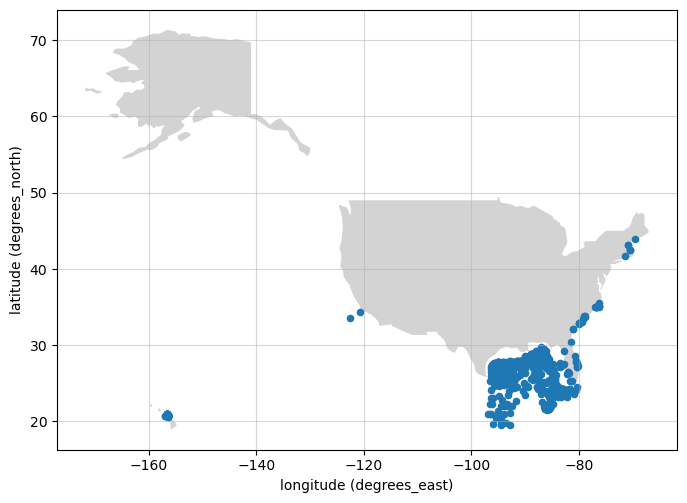

In [16]:
df_coords = pd.DataFrame(
    columns=["latitude (degrees_north)", "longitude (degrees_east)"]
)

for key in dict_out_final.keys():
    df_coords = pd.concat(
        [
            df_coords,
            dict_out_final[key][
                ["latitude (degrees_north)", "longitude (degrees_east)"]
            ],
        ]
    )

# drop all duplicates
df_coords_clean = df_coords.drop_duplicates(ignore_index=True)

# make the map
make_map(df_coords_clean)

## Lets explore those points on an interactive map

Just for fun, we can us [`geopandas.explore()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) to plot these points on an interactive map to browse around.

In [17]:
gdf = gpd.GeoDataFrame(
    df_coords_clean,
    geometry=gpd.points_from_xy(
        df_coords_clean["longitude (degrees_east)"],
        df_coords_clean["latitude (degrees_north)"],
    ),
    crs="EPSG:4326",
)

gdf.explore()

We hope this example demonstrates the flexibility of direct requests to the IOOS Data Catalog CKAN server and all the possibilities it provides. In this notebook we:

* Search the IOOS Data Catalog CKAN API with keywords.
* Found datasets matching our specified criteria.
* Collected all the data from each of the datasets matching our criteria.
* Created a simple map of the distribution of datasets which match our criteria.

To take this one step further, since we collected all the data from each of the datasets (in the dictionary `dict_out_final`) a user could integrate all of the oxygen observations together and start to build a comprehensive dataset. 

Additionally, a user could modify the CKAN query to search for terms outside of the CF standard names to potentially gather more datasets. 